In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from calibration import CharucoEstimator
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()
FIGURE_PATH = '../notebooks/figures'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -3, 'msi-regev': 0.06}

# Figure 3 - Animal Tracking

### trajectory example

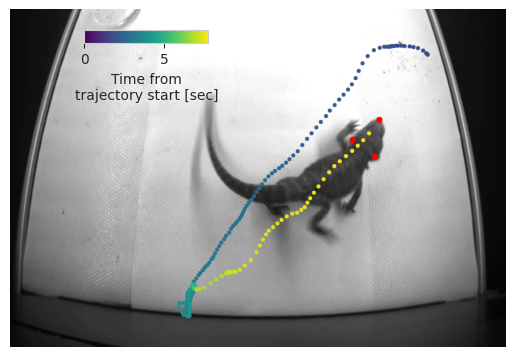

In [42]:
ld = Loader(725, 'front', is_debug=False, orm=orm, is_use_db=False, sec_before=4, sec_after=3.8)
xf = ld.frames_df.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(xf))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = xf.index[-2]
_, frame = next(ld.gen_frames([last_frame_id]))
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in xf.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = ld.frames_df[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

frame = frame[100:, :]
fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
ax.grid(False)
ax.axis('off')
secs = (xf.index.values - xf.index[0]) / 60
cbaxes = ax.inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')
fig.savefig('../notebooks/arena_figures/single_trajectory.pdf', dpi=250)

### Top trajectories

In [89]:
res = {}
w, h = 1440, 1080
for p in Path(config.EXPERIMENTS_DIR).rglob('*/predictions_gd/*.csv'):
    rf = pd.read_csv(p, index_col=0)
    rf['vid_name'] = p.stem
    res[p.stem] = rf
    
rdf = pd.concat(res.values())
rdf['x'] = rdf.cam_x * w
rdf['y'] = rdf.cam_y * h

In [91]:
rdf.vid_name.unique()

array(['top_20230624T073108', 'top_20230624T170111',
       'top_20230624T123110', 'top_20230624T183148',
       'top_20230624T150110', 'top_20230624T140110',
       'top_20230624T133110', 'top_20230624T113109',
       'top_20230624T130110', 'top_20230624T120109',
       'top_20230624T093109', 'top_20230624T153111',
       'top_20230624T143110', 'top_20230624T080108',
       'top_20230624T173111', 'top_20230624T160111',
       'top_20230624T083108', 'top_20230624T100109',
       'top_20230624T163111', 'top_20230624T070108',
       'top_20230624T180112', 'top_20230624T090108',
       'top_20230624T103109', 'top_20230624T110109',
       'top_20230619T150119', 'top_20230619T115834',
       'top_20230619T120118', 'top_20230619T115530',
       'top_20230619T180121', 'top_20230619T105530',
       'top_20230619T140119', 'top_20230619T173120',
       'top_20230619T170120', 'top_20230619T130119',
       'top_20230619T080042', 'top_20230619T070041',
       'top_20230619T183121', 'top_20230619T12

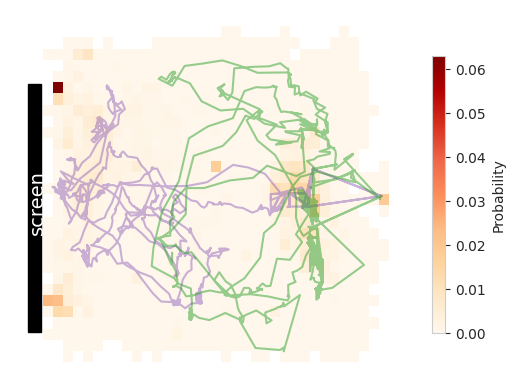

In [63]:
# plot 
example_vids = [('top_20230625T093053', 'tab:purple'), ('top_20230624T090108', 'tab:green')]
fig, ax = plt.subplots(1,1)
sns.histplot(data=rdf, x='x', y='y', bins=(35, 30), ax=ax, stat='probability', cmap=plt.cm.get_cmap('OrRd'),
             cbar=True, cbar_kws=dict(shrink=.75, label='Probability'))
for vid_name, color in example_vids:
    rf = rdf.query(f'vid_name=="{vid_name}"').sort_values(by='frame_id')
    ax.plot(rf.x, rf.y, color=color, alpha=0.5)
ax.add_patch(Rectangle((0, 150), 50, 700, color='k'))
ax.text(0, (150+700)//2, 'screen', rotation=90, color='w', va='bottom', fontsize=14)
ax.axis('off')
fig.savefig('../notebooks/arena_figures/arena_top_trajectories.pdf', dpi=250)

### Frog vs. Lizard

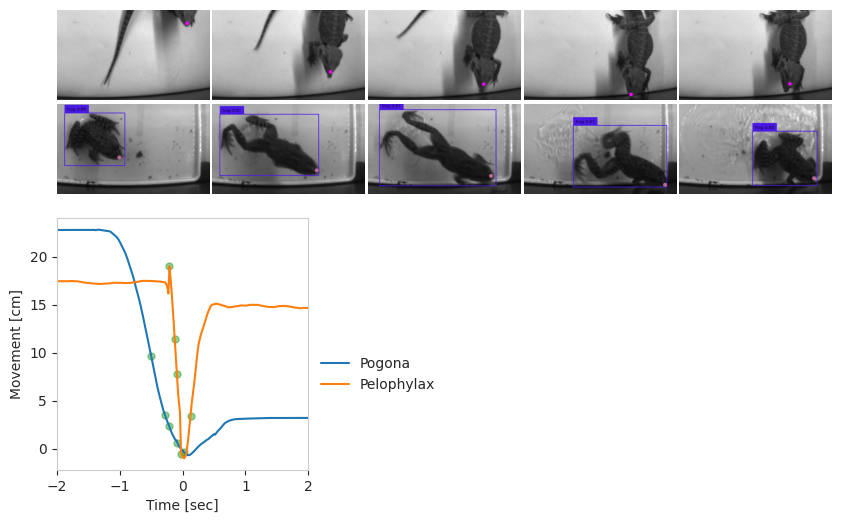

In [105]:
fig = plt.figure(figsize=(10, 6))
grid = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 4], hspace=0.1) 
upper_grid = grid[0, :].subgridspec(2, 5, wspace=0.02, hspace=0.001)
lower_grid = grid[1, :].subgridspec(1, 3, wspace=0.04)
upper_axes = upper_grid.subplots()
lower_axes = lower_grid.subplots()
# lower_axes[0].axis('equal')
# lower_axes[0].set_aspect('equal', adjustable='box')
for animal, frames_axes in [('pogona', upper_axes[0, :]), ('frog1', upper_axes[1, :])]:
    with open(f'/data/Pogona_Pursuit/notebooks/{animal}_strike_frames.pkl', 'rb') as f:
        data = pickle.load(f)
    
    if animal == 'frog1':
        animal = 'frog'
    frames, y_values = data['frames'], data['y_values']
    t = np.linspace(-2, 2, len(y_values))
    if animal == 'frog':
        y_values = -np.array(y_values)
        y_values = savgol_filter(y_values, 11, polyorder=0)
        y_values = 20 * (y_values - y_values.min()) / (y_values.max() - y_values.min()) - 1
        y_values = y_values.tolist()
        dy = 7
        y_values = dy * [y_values[0]] + y_values[:len(y_values)-dy]
        frames = [(i+dy, frame) for i, frame in frames]
    
    lower_axes[0].plot(t, y_values, label='Pogona' if animal == 'pogona' else 'Pelophylax')
    lower_axes[0].set_xlabel('Time [sec]')
    lower_axes[0].set_ylabel('Movement [cm]')
    lower_axes[0].scatter([t[k] for k, _ in frames], [y_values[k] for k, _ in frames], c='tab:green', s=25, alpha=0.5)
            
    for j, (_, annotated_frame) in enumerate(frames):
        frames_axes[j].imshow(annotated_frame[720:, 570:1180] if animal == 'frog' else annotated_frame[604:1000, 579:1250])
        frames_axes[j].axis('off')

lower_axes[0].legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 0.5))
lower_axes[0].margins(x=0)
lower_axes[0].set_box_aspect(1)
lower_axes[0].tick_params(bottom=True, left=True)
for i in [1, 2]:
    lower_axes[i].axis('off')
fig.savefig('../notebooks/arena_figures/frog_vs_lizard.pdf', dpi=250)

In [ ]:
# add deeplabcut to frog 

from analysis.predictors.deeplabcut import DLCPose

with open(f'/data/Pogona_Pursuit/notebooks/frog_strike_frames.pkl', 'rb') as f:
    data = pickle.load(f)
    
dlc = DLCPose('front')
dlc.init(data['frames'][0][1])

anno_frames = []
for frame_id, frame in data['frames']:
    pdf_ = dlc.predict(frame)
    annotated_frame = dlc.plot_predictions(frame.copy(), 0, pdf_, parts2plot=['nose'], colors=[(189,103,148)])
    anno_frames.append((frame_id, annotated_frame))
    # plt.figure()
    # plt.imshow(annotated_frame)
    
cap = cv2.VideoCapture('/media/sil2/Data/regev/frog_strike1.avi')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pdf = []
for i in range(n_frames):
    ret, frame = cap.read()
    pdf.append(dlc.predict(frame))

pdf = pd.concat(pdf)

data1 = data.copy()
data1['y_values'] = pdf['nose']['cam_y'].values.tolist()
data1['frames'] = anno_frames
with open(f'/data/Pogona_Pursuit/notebooks/frog1_strike_frames.pkl', 'wb') as f:
    pickle.dump(data1, f)

In [ ]:
# create lizard artifact

def create_lizard_artifact(strike_id, is_save=True):
    ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=False, sec_before=2, sec_after=2)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    y_values = pf['y'].values - SCREEN_Y_POS['reptilearn4']
    frames = []
    n_frames = len(y_values)
    frames2plot = [n_frames//2-30, n_frames//2-17, n_frames//2-13, n_frames//2-5, n_frames//2+1]
    
    fig, axes = plt.subplots(1, len(frames2plot), figsize=(20, 4))
    i, j = 0, 0
    for frame_id, frame in ld.gen_frames_around_strike():
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        cX = round(pf['cam_x'][frame_id])
        cY = round(pf['cam_y'][frame_id])
        cv2.circle(frame, (cX, cY), 8, (255, 0, 255), -1)
        if i in frames2plot:
            frames.append((i, frame))
            axes[j].imshow(frame[470:1000, 730:1250])
            j += 1
        i += 1
    fig.tight_layout()
    
    if is_save:
        with open('/data/Pogona_Pursuit/notebooks/pogona_strike_frames.pkl', 'wb') as f:
            pickle.dump({'frames': frames, 'y_values': y_values}, f)
            
create_lizard_artifact(strike_id=106, is_save=False)

# Figure 4 - Real-time strike detection

### Tongue Dataset

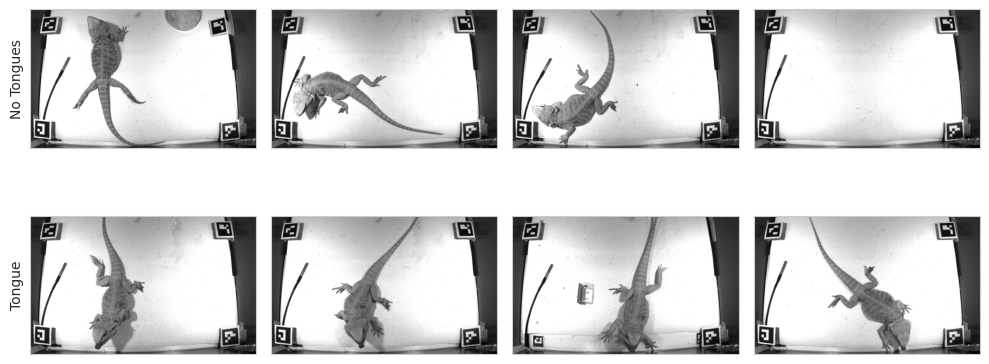

In [25]:
data = {
    'No Tongues': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671363126.3047485.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671549030.4634392.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671551711.601417.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/front_20221213T101615_17006.jpg'
    ],
    'Tongue': [
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545625.2763906.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671545655.1729114.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671707770.8067603.jpg',
        '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/front_20221213T101615_14380.jpg'
    ]
}

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, (title, frames) in enumerate(data.items()):
    for j, p in enumerate(frames):
        frame = cv2.imread(p)
        axes[i, j].imshow(frame[400:950, 300:1200])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        if j == 0:
            axes[i, j].set_ylabel(title)
fig.tight_layout()
fig.savefig(f'../notebooks/arena_figures/tongue_dataset.pdf', dpi=250)

### model evaluation

model analysis.predictors.tongue_out load from: /data/Pogona_Pursuit/output/models/tongue_out/20231128_162618
Loaded tongue dataset with: {'no_tongues': 5073, 'tongues': 1895}


  0%|          | 0/1045 [00:00<?, ?it/s]

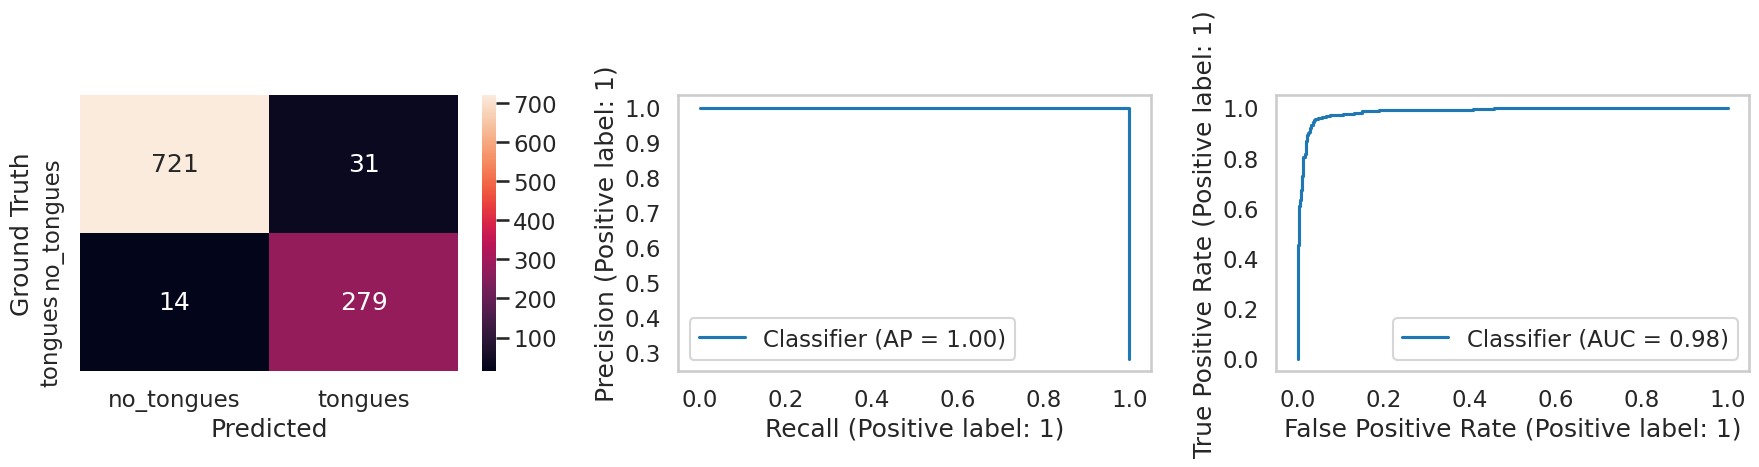

In [92]:
%matplotlib inline
from analysis.predictors.tongue_out import TongueTrainer

tt = TongueTrainer(model_path='/data/Pogona_Pursuit/output/models/tongue_out/20231128_162618')
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    tt.all_data_evaluation(axes, is_equalize_dataset=False, is_test_set=True)
    fig.tight_layout()
    fig.savefig(f'../notebooks/arena_figures/tongue_model_evaluation.pdf', dpi=250, bbox_inches="tight")

In [104]:
from torchviz import make_dot
import torch

x = torch.randn(1, 1, 224, 224).cuda()
yhat = tt.model(x)
make_dot(yhat.mean(), params=dict(list(tt.model.named_parameters()))).render("rnn_torchviz", format="pdf")

'rnn_torchviz.pdf'

In [101]:
tt.model

TongueModel(
  (embedding): ResNetPretrained(
    (conv5): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(

### Example jump trial

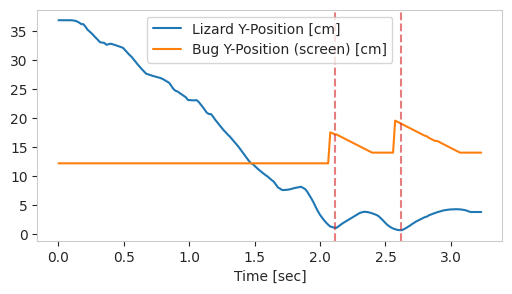

In [53]:
def plot_jump_example(trial_id, start_id=None):
    with orm.session() as s:
        orm_res = s.query(Trial, Block).join(Block, Block.id == Trial.block_id).filter(Trial.id==trial_id).first()
        traj = pd.DataFrame(orm_res[0].bug_trajectory)
        traj['time'] = pd.to_datetime(traj.time).dt.tz_localize(None)
        vid = [vid for vid in orm_res[1].videos if vid.cam_name=='front'][0]
        pose = DLCArenaPose(cam_name='front').load(video_db_id=int(vid.id))
        pose['time'] = pd.to_datetime(pose.time, unit='s')
        pose = pd.concat([pose['time'], pose['nose']], axis=1)
        
        df = pd.merge_asof(left=traj, right=pose, left_on='time', right_on='time', 
                           direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_traj', '_pose'))
    
    if start_id is not None:
        df = df.iloc[start_id:]
    df['time'] = (df.time - df.time.iloc[0]).dt.total_seconds()
    df['y_traj'] = -(df.y_traj * (53/1440)) + 40
    df['y_pose'] = df.y_pose - df.y_pose.min()
    df['y_pose'] = savgol_filter(df.y_pose.values, window_length=11, polyorder=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    sns.lineplot(data=df, x='time', y='y_pose', ax=ax, label='Lizard Y-Position [cm]')
    sns.lineplot(data=df, x='time', y='y_traj', ax=ax, label='Bug Y-Position (screen) [cm]')
    peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
    for t_ in df.time.iloc[peaks].values:
      plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
    # ax.set_ylim([0, 20])
    # ax.set_title(str(trial_id))
    ax.set_ylabel('')
    ax.set_xlabel('Time [sec]')
    ax.legend()
    ax.tick_params(bottom=True, left=True)
    fig.savefig(f'../notebooks/arena_figures/jump_example_{trial_id}.pdf', dpi=250, bbox_inches="tight")
    

# good trials: [5964, 1787, 2006, 1840]
plot_jump_example(5964, start_id=140)

### jump times before strikes

In [12]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
      Block, Block.id == Strike.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-10',
        Block.movement_type == 'jump_up'
    ).all()
    
    res = {}
    for strk, _, _ in tqdm(orm_res):
        try:
          ld = Loader(int(strk.id), 'front', sec_before=1.5, sec_after=0)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          t = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds().values
          traj = df.y_traj * (-1)
          traj = (traj - traj.min()) / (traj.max() - traj.min())
          # get the jumps using diff
          idx = np.where(np.diff(df.y_traj.values) < -10)[0]
          # if len(idx) > 0:
          #     # in case there more than 1 jump cancel the previous jumps
          #     traj[np.arange(idx[-1])] = traj[idx[-1]]
          # res[strk.id] = (t, df.y_pose.values, traj)
          res[strk.id] = t[idx[-1]]
        except Exception as exc:
            continue
                
res = {k: v for k, v in res.items() if v}

  0%|          | 0/275 [00:00<?, ?it/s]

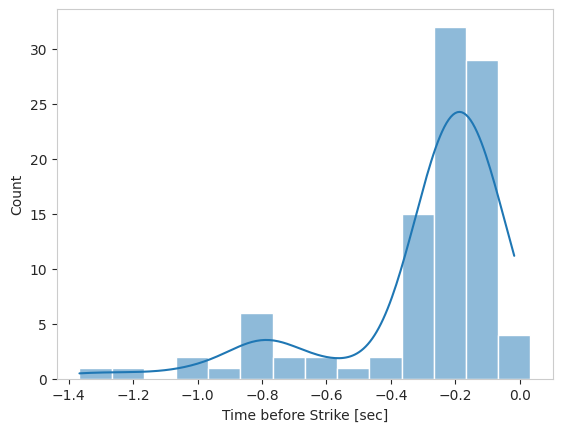

In [31]:
# with sns.plotting_context("talk"):
fig, ax = plt.subplots(1,1)
sns.histplot(x=list(res.values()), kde=True, ax=ax, binwidth=0.1)
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Time before Strike [sec]')
fig.savefig(f'../notebooks/arena_figures/jump_time_before_strikes.pdf', dpi=250, bbox_inches="tight")

Text(0.5, 0, 'Time before strike [sec]')

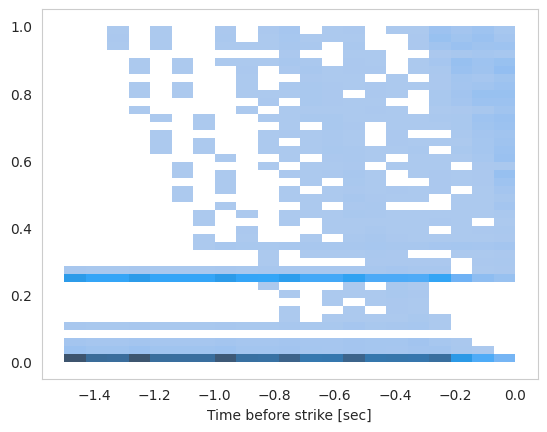

In [50]:
fig, ax = plt.subplots(1, 1)
avg_jump, avg_t = [], []
t = None
for strike_id, r in res.items():
    if t is None:
        t = r[0]
    traj = np.interp(t, r[0], r[2])
    avg_jump.append(traj)
    avg_t.append(t)
    # ax.plot(t, 2*traj, alpha=0.3, color='k')

avg_jump, avg_t = np.concatenate(avg_jump), np.concatenate(avg_t)
sns.histplot(x=avg_t, y=avg_jump)
# avg_jump = np.nanmean(np.vstack(avg_jump), axis=0)
# ax.plot(t, 2*avg_jump, color='red', linewidth=3)
ax.set_xlabel('Time before strike [sec]')
# fig.savefig('../notebooks/arena_figures/jumps_before_strike.pdf', dpi=250)

# Figure 5 - prey preferences and engagement

In [ ]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
      Block, Block.id == Strike.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18'
    ).all()
    
df = []
for strk, blk, exp in orm_res:
  miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
  df.append({'animal_id': exp.animal_id, 'movement_type': blk.movement_type, 'bug_size': blk.bug_size,
             'bug_type': strk.bug_type,
             'proj_strike': strk.projected_strike_coords, 'is_hit': strk.is_hit, 'miss_distance': miss_distance, 
             'proj_bug_x': strk.projected_leap_coords and strk.projected_leap_coords[0]})
  
df = pd.DataFrame(df)
df['proj_strike_x'] = df.proj_strike.map(lambda x: x[0] if x and len(x)==2 else None)
df['proj_strike_y'] = df.proj_strike.map(lambda x: x[1] if x and len(x)==2 else None)
df

### Polar plot of bug preferences

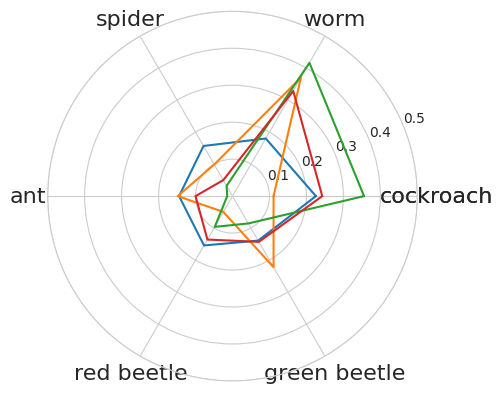

In [4]:
bugs = ['cockroach', 'worm', 'spider', 'ant', 'red_beetle', 'green_beetle']
bugs = bugs + [bugs[0]]
angles = np.linspace(0, 2*np.pi, len(bugs))
animals = ['PV91', 'PV148', 'PV95', 'PV97']
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
for animal_id in animals:
  vc = df.query(f'animal_id=="{animal_id}"').bug_type.value_counts(normalize=True).to_dict()
  vals = [vc.get(bug, 0) for bug in bugs]
  ax.plot(angles, vals)

ax.set_rmax(0.5)
ax.set_rticks([0.1, 0.2, 0.3, 0.4, 0.5])  # Less radial ticks
# ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.set_xticklabels(bugs)
ax.set_xticks(angles, [b.replace('_', ' ') for b in bugs], fontsize=16)
ax.grid(True)
# ax.set_title("A line plot on a polar axis", va='bottom')
fig.savefig('../notebooks/arena_figures/bugs_preferences.pdf', dpi=250)
plt.show()

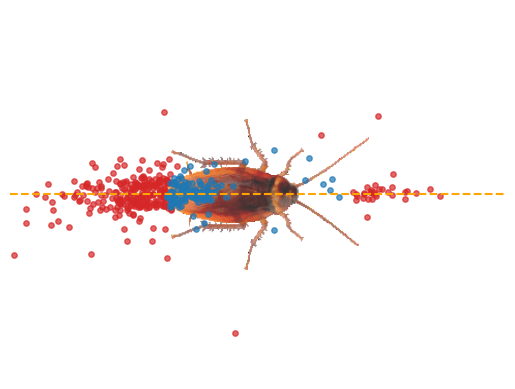

In [5]:
max_proj_x, max_proj_y = 180, 210

def plot_projected(ax, af):
    ax.axhline(0, linestyle='--', color='orange')
    for state, color in {0: 'tab:red', 1: 'tab:blue'}.items():
      af_ = af.query(f'is_hit=={state}')
      ax.scatter(af_.proj_strike_x, af_.proj_strike_y, c=color, label='hit' if state else 'miss', s=15, alpha=0.7)
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])
    
    im = cv2.imread((Path(config.OUTPUT_DIR).parent / 'pogona_hunter/src/assets/cockroach1.png').as_posix(), -1)
    im = ndimage.rotate(im, 270)
    im[np.where(im[:, :, 3] == 0)] = (255, 255, 255, 255)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # cax = ax.inset_axes([0.33, 0.4, 0.29, 0.2], zorder=-1)
    cax = ax.inset_axes([-70, -130, 150, 260], zorder=-1, transform=ax.transData)
    cax.imshow(im, aspect='auto', alpha=0.8)
    cax.axis('off')
    ax.axis('off')
    
fig, ax = plt.subplots(1, 1)
plot_projected(ax, df.query('animal_id=="PV91" and bug_type=="cockroach"'))
fig.savefig('../notebooks/arena_figures/cockroach_with_hits.pdf', dpi=250)

### Engagement

In [212]:
def get_engagement_performance_data():
    conditions = [
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.not_in(BAD_ANIMALS),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18',
    ]
    with orm.session() as s:
        strikes_res = s.query(Strike, Block, Experiment).join(
          Block, Block.id == Strike.block_id).join(
          Experiment, Experiment.id == Block.experiment_id).filter(*conditions).all()
        strikes_df = []
        for strk, blk, exp in strikes_res:
          miss_distance = np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2)
          strikes_df.append({'strike_id': strk.id, 'animal_id': exp.animal_id, 'bug_type': strk.bug_type, 
                             'time': strk.time, 'movement_type': blk.movement_type,
                             'trial_id': strk.trial_id, 'block_id': blk.id, 'bug_speed': strk.calc_speed, 
                             'block_speed': blk.bug_speed, 'is_hit': strk.is_hit, 'miss_distance': miss_distance})
        strikes_df = pd.DataFrame(strikes_df)
        strikes_df['day'] = strikes_df.time.dt.floor('d').copy()
        
        trials_res = s.query(Trial, Block, Experiment).join(
          Block, Block.id == Trial.block_id).join(
          Experiment, Experiment.id == Block.experiment_id).filter(*conditions).all()
        eng_df = []
        for tr, blk, exp in trials_res:
            eng_df.append({'block_id': blk.id, 'trial_id': tr.id, 'animal_id': exp.animal_id, 
                           'is_strike': len(tr.strikes) > 0, 'time': tr.start_time})
        eng_df = pd.DataFrame(eng_df)
        eng_df['day'] = eng_df.time.dt.floor('d').copy()
        eng_df = eng_df.groupby(['animal_id', 'day']).trial_id.count().reset_index()
        # eng_df = eng_df.groupby(['animal_id', 'day']).is_strike.agg(['sum', 'count']).reset_index()
        # eng_df['engagement'] = (eng_df['sum'] / eng_df['count']) * 100
    
    return strikes_df, eng_df

sf, ef = get_engagement_performance_data()
ef

,animal_id,day,trial_id
0,PV148,2023-07-07,60
1,PV148,2023-07-08,110
2,PV148,2023-07-09,110
3,PV148,2023-07-10,110
4,PV148,2023-07-11,109
...,...,...,...
183,PV99,2023-07-29,55
184,PV99,2023-07-30,55
185,PV99,2023-07-31,50
186,PV99,2023-08-01,80


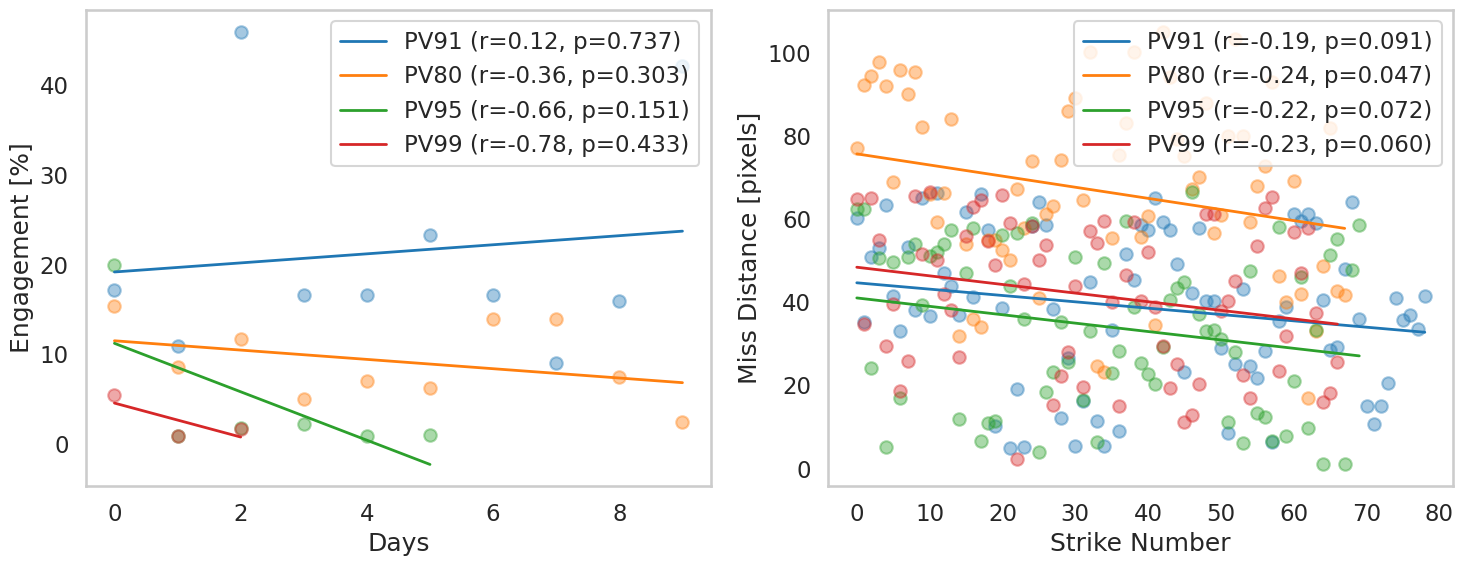

In [215]:
ANIMALS = ['PV91', 'PV80', 'PV95', 'PV99']
EXAMPLE_ANIMAL = 'PV91'
COLORS = list(TABLEAU_COLORS.values())

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for i, animal_id in enumerate(ANIMALS):
        # g1 = ef.query(f'animal_id=="{animal_id}"').sort_values('day')
        g1 = sf.query(f'animal_id=="{animal_id}" and bug_type=="spider"').groupby('day').strike_id.count().iloc[-10:]
        g1 = pd.merge(g1, ef.query(f'animal_id=="{animal_id}"'), left_index=True, right_on='day')
        g1 = g1.strike_id / g1.trial_id * 100
        x = np.arange(len(g1))
        y = g1.values
        axes[0].scatter(x, y, color=COLORS[i], alpha=0.4)
        plot_regression(axes[0], x, y, color=COLORS[i], prefix=animal_id)
        axes[0].set_ylabel('Engagement [%]')
        axes[0].set_xlabel('Days')
        
        g2 = sf.query(f'animal_id=="{animal_id}" and is_hit and movement_type=="random_low_horizontal"').sort_values(by='strike_id')
        x = np.arange(len(g2))
        y = g2.miss_distance.values
        # if animal_id == EXAMPLE_ANIMAL:
        axes[1].scatter(x, y, color=COLORS[i], alpha=0.4)
        plot_regression(axes[1], x, y, color=COLORS[i], prefix=animal_id)
        axes[1].set_ylabel('Miss Distance [pixels]')
        axes[1].set_xlabel('Strike Number')
    fig.tight_layout()
    fig.savefig('../notebooks/arena_figures/engagement.pdf', dpi=250)

  0%|          | 0/2061 [00:00<?, ?it/s]

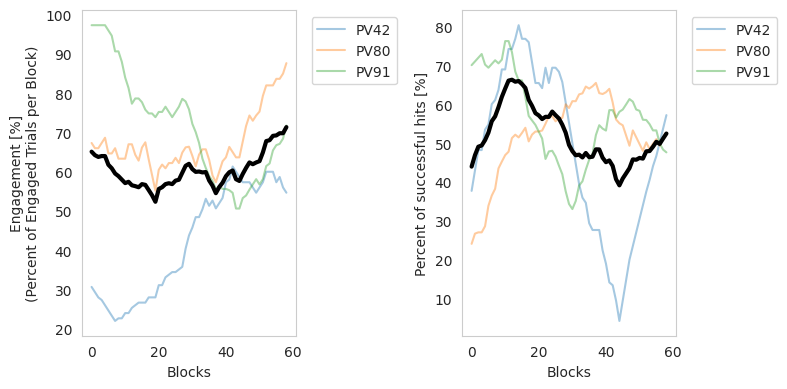

In [71]:
def load_engagement():
    eng_ = []
    with orm.session() as s:
        exps = s.query(Experiment).filter(
            Experiment.arena.in_(['reptilearn4', 'msi-regev']),
            Experiment.animal_id.not_in(BAD_ANIMALS),
            Experiment.animal_id.startswith('PV'),
            # Experiment.start_time > '2023-04-18'
        ).all()
        for exp in tqdm(exps):
            for blk in exp.blocks:
                if blk.movement_type in ['jump_up']:
                    continue
                if len(blk.strikes) < 2:
                    continue
                for tr in blk.trials:
                    trial_dict = {'trial_id': tr.id, 'animal_id': exp.animal_id, 'time': tr.start_time, 
                                  'is_strike': len(tr.strikes) > 0,
                                  'block_id': blk.id, 'bug_speed': blk.bug_speed}
                    
                    trial_dict['avg_miss'] = np.nanmean([np.sqrt((strk.x - strk.bug_x)**2 + (strk.y - strk.bug_y)**2) 
                                                         for strk in tr.strikes]) if tr.strikes else None
                    trial_dict['n_hits'] = sum([strk.is_hit for strk in tr.strikes])
                    trial_dict['n_strikes'] = len(tr.strikes)
                    eng_.append(trial_dict)

    eng_ = pd.DataFrame(eng_)
    eng_['day'] = eng_.time.dt.floor('d').copy()
    for animal_id in eng_.animal_id.unique():
        af_ = eng_.query(f'animal_id=="{animal_id}"')
        first_day = af_.day.sort_values().iloc[0]
        eng_.loc[af_.index, 'day_num'] = (af_.day - first_day).dt.days
    return eng_


def plot_engagement(eng, n_trials=50, start_block=10):
    animals2drop = ['PV85', 'PV97', 'PV148']
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    g = eng.groupby(['animal_id', 'block_id']).is_strike.agg(['sum', 'count']).reset_index()
    g['engagement'] = (g['sum'] / g['count']) * 100
    avg = []
    for animal_id in g.animal_id.unique():
        if animal_id in animals2drop:
            continue
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['engagement'] = savgol_filter(g_.engagement, window_length=15, polyorder=0, mode='nearest')
        y = g_['engagement'].iloc[start_block:].values
        blocks = np.arange(len(y))
        axes[0].plot(blocks, y, label=animal_id, alpha=0.4)
        avg.append(y)
    
    # random
    x = np.arange(len(y))
    # for m, q, n in [(1.6, 0.009, 25), (1.4, 0.03, 33)]:
    #     y = m*x + np.random.normal(0,1,len(x)) + n
    #     ch = np.random.choice(x[:-20])
    #     y[ch:ch+20] = y[ch:ch+20] - q*np.arange(20) ** 2 
    #     ax.plot(x, y, label=f'PV{m}'.replace('.', ''), alpha=0.4)
    #     avg.append(y)
    
    axes[0].plot(x, np.vstack(avg).mean(axis=0), color='k', linewidth=3)
    axes[0].grid(False)
    axes[0].set_xlabel('Blocks')
    axes[0].set_ylabel('Engagement [%]\n(Percent of Engaged Trials per Block)')
    axes[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    # g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'avg_miss_y': np.nanmean}).reset_index()
    g = eng.query('is_strike').groupby(['animal_id', 'block_id']).agg({'n_hits': np.nansum, 'n_strikes': np.nansum}).reset_index()
    g['accuracy'] = (g['n_hits'] / g['n_strikes']) * 100
    avg = []
    for animal_id in g.animal_id.unique():
        g_ = g.query(f'animal_id=="{animal_id}"').reset_index()
        if animal_id in animals2drop:
            continue
        if len(g_) < n_trials:
            continue
        g_ = g_.iloc[:n_trials]
        g_['accuracy'] = savgol_filter(g_.accuracy, window_length=19, polyorder=0, mode='nearest')
        y = g_['accuracy'].iloc[start_block:].values
        blocks = np.arange(len(y))
        axes[1].plot(blocks, y, label=animal_id, alpha=0.4)
        avg.append(y)
        
    x = np.arange(len(y))
    axes[1].plot(x, np.vstack(avg).mean(axis=0), color='k', linewidth=3)
    axes[1].grid(False)
    axes[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    axes[1].set_xlabel('Blocks')
    axes[1].set_ylabel('Percent of successful hits [%]')
    
    fig.tight_layout()
    fig.savefig('../notebooks/arena_figures/engagement.pdf', dpi=250)

eng0 = load_engagement()
plot_engagement(eng0, start_block=1, n_trials=60)

In [ ]:
cols = 10
rows = int(np.ceil(len(res) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
axes = axes.flatten()
for i, (trial_id, r) in enumerate(res.items()):
    try:
        t = r[0] - r[0][0]
        traj = -r[2].copy()
        traj = (traj - traj.min()) / (traj.max() - traj.min())
        idx = np.where(np.diff(r[2]) < -10)[0]
        if len(idx) > 0:
            traj[np.arange(idx[-1])] = traj[idx[-1]]
        
        axes[i].plot(t, traj)
        axes[i].set_title(str(trial_id))
    except Exception as exc:
        print(exc)
fig.tight_layout()

In [ ]:
plt.plot(r[0], r[2])
idx = np.where(np.diff(r[2]) < -10)[0]
plt.scatter(r[0][idx], r[2][idx], c='red')

In [53]:
matrices = {}
for strike_id, r in res.items():
    fig = plt.figure()
    plt.axis('off')
    plt.plot(r[0], r[2], color='black', antialiased=False, linewidth=1)
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,)).copy()
    plt.close(fig)
    data[data==0] = 1
    data[data==255] = 0
    matrices[strike_id] = data

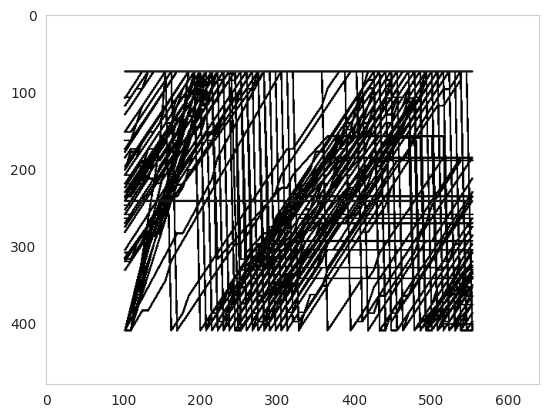

In [64]:
m = np.sum(list(matrices.values()), 0)
m[m==0] = 255
plt.imshow(m)

In [ ]:
fig.canvas.

In [ ]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for trial_id in list(res.keys())[::-1]:
  res_ = res[trial_id]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(trial_id))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

In [3]:
with orm.session() as s:
    orm_res = s.query(Video, Block, Experiment).join(
      Block, Block.id == Video.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'PV91',
        Video.cam_name == 'front'
    ).all()

In [4]:
dlc = DLCArenaPose(cam_name='front', orm=orm)
res = {}
days = set()
for vid, _, _ in tqdm(orm_res):
  try:
    pose_df = dlc.load(video_db_id=int(vid.id))
    res[int(vid.id)] = [pose_df.nose.x.values, pose_df.nose.y.values,
                        len(pose_df) * [vid.start_time.strftime('%Y%m%d')]]
    
  except Exception:
    continue

  0%|          | 0/306 [00:00<?, ?it/s]

In [5]:
xf = {'x': [], 'y': [], 'video_id': [], 'day': []}
for vid_id, r in res.items():
  x, y, day = r[0], r[1], r[2]
  xf['x'].extend(x.tolist())
  xf['y'].extend(y.tolist())
  xf['day'].extend(day)
  xf['video_id'].extend([vid_id for _ in range(len(x))])
  
xf = pd.DataFrame(xf)
xf = xf.query('0 <= x < 43 and y >= -2')
xf

,x,y,video_id,day
0,42.485432,0.383447,495,20230530
1,42.484500,0.386294,495,20230530
2,42.488717,0.389675,495,20230530
3,42.478963,0.392972,495,20230530
4,42.478083,0.393868,495,20230530
...,...,...,...,...
3533749,15.110024,-1.807199,1198,20230619
3533750,14.909484,-1.861303,1198,20230619
3533751,14.741387,-1.909137,1198,20230619
3533752,14.620501,-1.931702,1198,20230619


In [6]:
def get_out_of_experiment_pose(animal, day):
    tracking_dir = Path(config.EXPERIMENTS_DIR) / animal / day / 'tracking' / 'predictions'
    if not tracking_dir.exists():
        print(f'{tracking_dir} not exist')
        return []
    
    pose_ = []
    for p in tracking_dir.rglob('*.csv'):
        df = pd.read_csv(p, index_col=0)
        if df.empty:
            continue
        df = df[~df.x.isna()]
        pose_.append(df[['frame_id', 'x', 'y']])
    return pd.concat(pose_)

xf_ = get_out_of_experiment_pose('PV91', '20230619')

In [7]:
caliber = CharucoEstimator('top', is_debug=False)
cap = cv2.VideoCapture('/data/Pogona_Pursuit/output/experiments/PV91/20230621/tracking/top_20230621T140038.mp4')
ret, frame = cap.read()
caliber.init(frame)
cap.release()

In [50]:
x = xf_[['x', 'y']].apply(lambda pos: caliber.get_location(*pos), axis=1)

In [ ]:
xf_ = pd.DataFrame(x.tolist(), columns=('x', 'y'))
sns.scatterplot(data=xf_, x='x', y='y')

In [ ]:
days_res = {}
orig_days = {}
for day in tqdm(xf.day.unique()):
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        orig_days[day] = xf_
        zf_ = xf_[['x', 'y']].apply(
                lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        days_res[day] = zf_

In [ ]:
day_df = pd.concat(list(days_res.values()))
sns.histplot(data=day_df, x='x', y='y')

In [ ]:
day_df = pd.concat(list(orig_days.values()))
sns.histplot(data=day_df, x='y', y='x')
xf_ = orig_days['20230611']
c = 0
for group_id, idx in xf_.groupby(xf_.frame_id.diff().ne(1).cumsum()).groups.items():
    if c >= 3:
        break
    if len(idx) > 50:
        sns.lineplot(data=xf_.loc[idx].sort_values(by='frame_id'), x='y', y='x')
        c += 1
plt.gca().invert_xaxis()

In [4]:
cap = cv2.VideoCapture((p.parent.parent / p.with_suffix('.mp4').name).as_posix())
ret, frame = cap.read()
h, w = frame.shape[:2]
cap.release

<function VideoCapture.release>

In [ ]:
for name, rf in res.items():
    plt.figure()
    plt.plot(rf.cam_x*w, rf.cam_y*h)
    plt.title(name)
    plt.xlim([0, 1400])
    plt.ylim([0, 1080])

In [47]:
frames = {}
for name, video_path in {'light': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T080107.mp4',
                         'good': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T153805.mp4'}.items():
    cap = cv2.VideoCapture(video_path)
    ret, frames[name] = cap.read()
    cap.release()

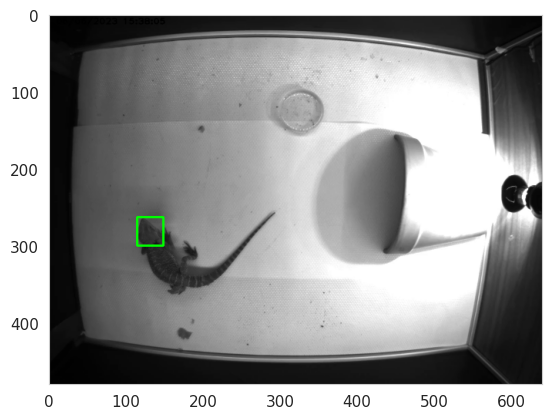

In [54]:
%matplotlib inline
from analysis.predictors.pogona_head import PogonaHead

ph = PogonaHead('top')
ph.init(None)
det, image = ph.predict(frames['good'], is_draw_pred=True)
if image is not None:
    plt.imshow(image)
    plt.show()

In [ ]:
traj_ids = xf.groupby('video_id').y.var().sort_values(ascending=False).iloc[160:190].index.tolist()

# days = set()
# for vid_id in traj_ids:
#   xf_ = xf.query(f'video_id=={vid_id}')
#   days.add(xf_.day.iloc[0])
#   plt.scatter(xf_.x, xf_.y, s=5, alpha=0.4, c='tab:green', marker='.')

for day in days:
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        zf_ = xf_[['x', 'y']].apply(
            lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        # xf_ = xf_.query('0 <= x < 43 and y >= -2')
        plt.scatter(zf_.x, zf_.y, s=5, alpha=0.4, c='tab:purple', marker='.')

plt.gca().invert_xaxis()

In [ ]:
for i in range(30):
    ld = Loader(int(orm_res[i][0].id), 'front', is_load_pose=True, is_use_db=False)
    # ld.play_strike(n_frames_back=100, n_frames_forward=100)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    plt.figure()
    plt.plot(t, pf['y'] - SCREEN_Y_POS['reptilearn4'])
    plt.title(i)
# z = [pf[m].values - (SCREEN_Y_POS['reptilearn4'] if m == 'y' else 0) for m in metrics.keys()]

In [14]:
with orm.session() as s:
    orm_res = s.query(Trial, Block, Experiment).join(
      Block, Block.id == Trial.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-01',
        Block.movement_type == 'jump_up'
    ).all()
    
    res = {}
    for tr, _, _ in tqdm(orm_res):
      if len(tr.strikes) < 2:
        continue
      res[tr.id] = []
      for strk in tr.strikes:
        try:
          ld = Loader(int(strk.id), 'front', sec_before=0.5, sec_after=0.5)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          # df['time'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
          res[tr.id].append((df.time.values, df.y_pose.values, df.y_traj.values))
        except Exception as exc:
          print(f'{strk.id} - {exc}')
                
res = {k: v for k, v in res.items() if v}

  0%|          | 0/1494 [00:00<?, ?it/s]

1234 - traj_df is empty
1235 - traj_df is empty
1231 - traj_df is empty
1233 - traj_df is empty
1230 - traj_df is empty
1232 - traj_df is empty
1005 - traj_df is empty
1007 - traj_df is empty
1006 - traj_df is empty
1042 - frames_df is empty after loading
1051 - traj_df is empty
1052 - traj_df is empty
1068 - traj_df is empty
1069 - traj_df is empty
1071 - traj_df is empty
1072 - traj_df is empty
1073 - traj_df is empty
1074 - traj_df is empty
1070 - traj_df is empty
2840 - Video prediction was not found for video db id: 3343
2838 - Video prediction was not found for video db id: 3343
2839 - Video prediction was not found for video db id: 3343
2836 - Video prediction was not found for video db id: 3343
2837 - Video prediction was not found for video db id: 3343
2846 - Video prediction was not found for video db id: 3347
2847 - Video prediction was not found for video db id: 3347
2848 - Video prediction was not found for video db id: 3347
2849 - Video prediction was not found for video 

In [ ]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for trial_id in list(res.keys())[::-1]:
  res_ = res[trial_id]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(trial_id))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

In [18]:
res.keys()

dict_keys([1776, 1809, 1778, 1782, 1811, 1783, 1793, 1786, 1787, 1785, 2006, 2008, 2009, 2015, 2005, 1796, 1794, 2017, 2018, 2023, 2021, 2022, 1816, 1813, 1997, 1818, 2025, 2026, 2027, 2029, 2035, 2037, 1838, 1840, 1842, 1846, 1848, 1850, 1860, 1862, 1864, 1867, 1868, 1869, 1870, 1877, 1873, 1892, 1890, 1894, 1897, 1898, 1899, 1907, 1903, 1904, 1905, 1911, 1908, 1909, 1912, 1917, 1920, 1931, 1928, 1929, 1934, 1936, 1942, 1938, 1941, 1953, 1954, 1755, 1756, 1757, 2012, 2010, 1994, 2003, 1992, 2001, 2002, 1995, 3588, 3665, 3775, 5262, 5179, 5199, 5212, 5222, 5232, 5136, 5157, 5194, 5919, 5932, 5954, 5955, 5958, 5964, 5965, 5977, 6002, 6004, 6006, 6014, 6056, 6060, 6062, 6066, 6068])

In [ ]:
for trial_id, res_ in res.items():
    fig, axes = plt.subplots(2, 1, figsize=(10, 3))
    t = np.concatenate([r[0] for r in res_])
    tidx = t.argsort()
    t = t[tidx]
    t = pd.Series(t - t[0]).dt.total_seconds().values
    axes[0].plot(t, np.concatenate([r[1] for r in res_])[tidx])
    axes[0].set_xticks([])
    axes[0].set_title(str(trial_id))
    axes[1].plot(t, np.concatenate([r[2] for r in res_])[tidx])
    axes[1].invert_yaxis()

In [ ]:
n = 50
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for r in res:
  if i >= n:
    break
  if (r[2] < 700).any():
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
    i += 1

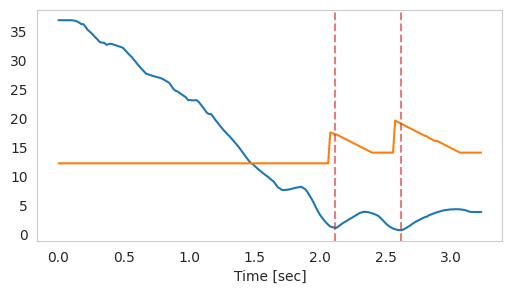

In [13]:
orm_res

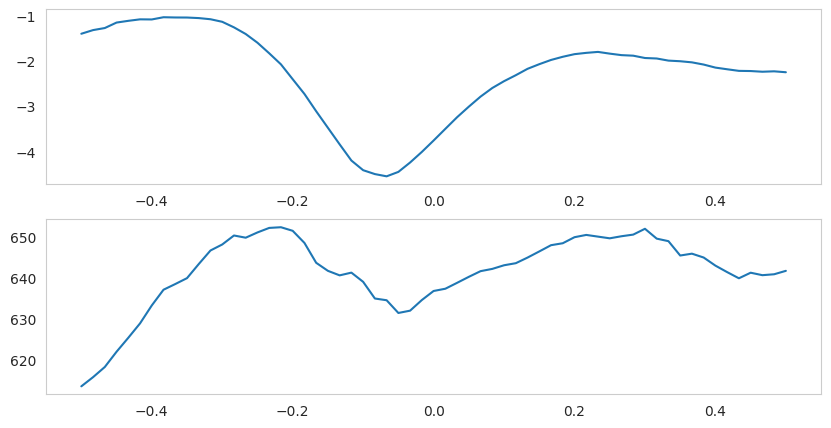

In [44]:
idx = [i for i, r in enumerate(res) if (r[2] < 700).any()]

pose_y = np.nanmean(np.vstack([x[1] for x in np.array(res)[idx]]), axis=0)
traj_y = np.nanmean(np.vstack([x[2] for x in np.array(res)[idx]]), axis=0)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(res[0][0], pose_y)
axes[1].plot(res[0][0], traj_y)

In [13]:
df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                   direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
df

,time,cam_x,cam_y,prob,x_pose,y_pose,x_traj,y_traj
0,2023-05-31 09:36:56.289805824,881.322327,713.982605,0.999980,12.891213,5.116192,1639,755
1,2023-05-31 09:36:56.306471936,881.275452,713.964050,0.999980,12.893800,5.117261,1639,755
2,2023-05-31 09:36:56.323139072,881.338379,713.873901,0.999980,12.890327,5.122453,1635,755
3,2023-05-31 09:36:56.339804928,881.237244,713.778809,0.999978,12.895909,5.127930,1631,755
4,2023-05-31 09:36:56.356472064,881.165100,713.767151,0.999977,12.899891,5.128601,1627,755
...,...,...,...,...,...,...,...,...
236,2023-05-31 09:37:00.223077888,504.704010,904.293640,0.999876,21.735356,-0.189697,1267,705
237,2023-05-31 09:37:00.239744000,504.537811,903.236938,0.999925,21.745105,-0.128837,1267,705
238,2023-05-31 09:37:00.256411136,504.421417,902.344360,0.999951,21.751933,-0.077429,1267,705
239,2023-05-31 09:37:00.273076992,504.478088,901.922485,0.999956,21.748608,-0.053131,1267,705


In [20]:
df['time2'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
df

,time,cam_x,cam_y,prob,x_pose,y_pose,x_traj,y_traj,time2
0,2023-05-31 09:36:56.289805824,881.322327,713.982605,0.999980,12.891213,5.116192,1639,755,-1.999968
1,2023-05-31 09:36:56.306471936,881.275452,713.964050,0.999980,12.893800,5.117261,1639,755,-1.983302
2,2023-05-31 09:36:56.323139072,881.338379,713.873901,0.999980,12.890327,5.122453,1635,755,-1.966635
3,2023-05-31 09:36:56.339804928,881.237244,713.778809,0.999978,12.895909,5.127930,1631,755,-1.949969
4,2023-05-31 09:36:56.356472064,881.165100,713.767151,0.999977,12.899891,5.128601,1627,755,-1.933302
...,...,...,...,...,...,...,...,...,...
236,2023-05-31 09:37:00.223077888,504.704010,904.293640,0.999876,21.735356,-0.189697,1267,705,1.933304
237,2023-05-31 09:37:00.239744000,504.537811,903.236938,0.999925,21.745105,-0.128837,1267,705,1.949970
238,2023-05-31 09:37:00.256411136,504.421417,902.344360,0.999951,21.751933,-0.077429,1267,705,1.966637
239,2023-05-31 09:37:00.273076992,504.478088,901.922485,0.999956,21.748608,-0.053131,1267,705,1.983303


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=df, x='time', y='y_pose', ax=axes[0])
sns.lineplot(data=df, x='time', y='y_traj', ax=axes[1])

In [ ]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
        Block, Block.id == Strike.block_id).join(
        Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'BP28'
    ).all()
    
for strk, _, _ in orm_res:
    ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False)
    ld.play_strike(n_frames_back=100, n_frames_forward=100)
    
    
strk = orm_res[-2][0]
ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False, sec_before=2, sec_after=2)
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = None
for i, frame in ld.gen_frames_around_strike():
    if writer is None:
        h, w = frame.shape[:2]
        writer = cv2.VideoWriter('/data/Pogona_Pursuit/output/experiments/BP28/frog_strike1.avi', fourcc, 60, (w, h), 0)
    writer.write(frame)

writer.release()